In [1]:
#! micromamba create --name pytorch -c conda-forge -c defaults -c pytorch pytorch-gpu matplotlib h5py ipykernel

In [1]:
import os
# os.chdir('/disk/scratch2/nkudryas/BAND-torch/')
os.environ["CUDA_VISIBLE_DEVICES"]= "5"

# import matplotlib.pyplot as plt
import numpy as np
import h5py
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

from lfads_torch.benchmark.biRNN_decoder import Decoder
from lfads_torch.metrics import r2_score

In [2]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = r2_score(pred_vel,vel)

    assert np.allclose(np.arange(8),np.unique(dir_index))
    avg_vel = [np.mean(vel[dir_index==d], axis=0) for d in range(8)]
    total_var = [np.sum((vel[dir_index==d] - avg_vel[d])**2) for d in range(8)]
    expl_var  = [np.sum((pred_vel[dir_index==d] - vel[dir_index==d])**2) for d in range(8)] 
    for d in range(8):
        if total_var[d] == 0:
            total_var[d] = np.nan
    R2_UIVE = np.nanmean([1 - expl_var[d] / total_var[d] for d in range(8)])

    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%\n R2_UIVE = {R2_UIVE*100:.0f}%')

def get_trials2plot(pos, avg_pos, dir_index, epochs,epoch=1):
    '''
    Select the trials to plot based on the distance between 
    the average position and the position in single trials

    Parameters
    ----------
    pos : np.ndarray
        The position in single trials
    avg_pos : np.ndarray
        The average position
    dir_index : np.ndarray
        The direction index
    epochs : np.ndarray
        The epochs
    epoch : int, optional
        The epoch to consider, by default 1 (adaptation)

    Returns
    -------
    np.ndarray
        The trials to plot
    '''
    trials2plot = np.zeros_like(epochs)
    for d in np.unique(dir_index):
        mask = (epochs == epoch) & (dir_index == d)
        # print(mask)
        dist = ((pos - avg_pos) ** 2).sum(-1).sum(-1)
        dist[~mask] = -np.inf
        # print(dist)
        idx_max = np.argmax(dist)
        # print(idx_max)
        trials2plot[idx_max] = 1
    return trials2plot

In [12]:
area = 'all'
short_dataset_name = 'Chewie_CO_FF_2016-10-07'
# short_dataset_name = 'Mihili_CO_FF_2014-02-03'
dataset_name = f'{short_dataset_name}_session_vel_{area}_spikes_go'
loadpath = f'/disk/scratch/nkudryas/BAND-torch/datasets/{dataset_name}.h5'

# loadpath = f'/disk/scratch2/nkudryas/BAND-torch/datasets/Jango_20140820_WB_004_neural_5ms_cvs1.h5'

h5file = h5py.File(loadpath, 'r')

# print(h5file.keys())

train_data_raw=h5file['train_recon_data'][()].astype(np.float32)
valid_data_raw=h5file['valid_recon_data'][()].astype(np.float32)
train_behavior=h5file['train_behavior'][()].astype(np.float32)
valid_behavior=h5file['valid_behavior'][()].astype(np.float32)
train_epoch=h5file['train_epoch'][()].astype(np.float32)
valid_epoch=h5file['valid_epoch'][()].astype(np.float32)
train_inds=h5file['train_inds'][()].astype(np.float32)
valid_inds=h5file['valid_inds'][()].astype(np.float32)

train_target_direction=h5file['train_target_direction'][()].astype(np.float32)
valid_target_direction=h5file['valid_target_direction'][()].astype(np.float32)
# print(h5file.keys())
h5file.close()

dir_index = np.array([
        sorted(set(valid_target_direction)).index(i) for i in valid_target_direction
    ])

In [5]:
train_data_raw[:].shape

(465, 101, 207)

In [8]:
train_data = train_data_raw
valid_data = valid_data_raw
# train an RNN decoder to predict behavior from neural activity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
T = train_data.shape[1] # number of time bins
assert M == 2, 'only 2D behavior is expected'
rnn = Decoder(input_size=N, 
              rnn_size=128,
              hidden_size=128, 
              output_size=M, 
              seq_len=T, 
              num_layers=1,
              spike_dropout_rate = 0.3,
              dropout = 0.2).to(device)


# Loss and optimizer
loss = nn.MSELoss()
# higher weight decay for RNN
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9)

# Convert numpy arrays to torch tensors
inputs = torch.from_numpy(train_data).to(device)
behaviors = torch.from_numpy(train_behavior).to(device)
test_inputs = torch.from_numpy(valid_data).to(device)
test_behaviors = torch.from_numpy(valid_behavior).to(device)

# Train the model
dataset_name = 'Mihili'
num_epochs = 1000
batch_size = 100
for epoch in range(num_epochs):

    batch_indices = list(range(inputs.shape[0]))
    batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

    # print(batch)

    # Forward pass
    outputs = rnn(inputs[batch])
    cost = loss(outputs, behaviors[batch]) 

    # Backward and optimize
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    scheduler.step(cost)

    # print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.4f}, Test Loss: {test_cost.item():.4f}')
    # print epoch and R2
    if (epoch+1) % 10 == 0:
        # predict on test
        rnn.eval()
        train_outputs = rnn(inputs)
        train_cost = loss(train_outputs, behaviors) 
        test_outputs = rnn(test_inputs)
        test_cost = loss(test_outputs, test_behaviors)
        rnn.train()
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_cost.item():.4f}, Test Loss: {test_cost.item():.4f}, R2: {r2_score(test_behaviors, test_outputs).item():.4f}')
        

/disk/scratch/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Epoch [10/1000], Loss: 43.7041, Test Loss: 45.0149, R2: -6.8020
Epoch [20/1000], Loss: 33.7923, Test Loss: 34.7351, R2: -0.9292
Epoch [30/1000], Loss: 26.6421, Test Loss: 27.5787, R2: -0.4930
Epoch [40/1000], Loss: 20.2985, Test Loss: 21.2186, R2: 0.0605
Epoch [50/1000], Loss: 15.5188, Test Loss: 16.5073, R2: 0.4090
Epoch [60/1000], Loss: 12.0821, Test Loss: 13.0844, R2: 0.6235
Epoch [70/1000], Loss: 9.6610, Test Loss: 11.0132, R2: 0.6938
Epoch [80/1000], Loss: 8.0606, Test Loss: 9.5151, R2: 0.7628
Epoch [90/1000], Loss: 6.2727, Test Loss: 7.5572, R2: 0.8393
Epoch [100/1000], Loss: 5.5637, Test Loss: 6.9041, R2: 0.8674
Epoch [110/1000], Loss: 4.8130, Test Loss: 6.4078, R2: 0.8682
Epoch [120/1000], Loss: 4.9245, Test Loss: 6.4836, R2: 0.8839
Epoch [130/1000], Loss: 3.9746, Test Loss: 5.5097, R2: 0.8992
Epoch [140/1000], Loss: 3.7737, Test Loss: 5.3017, R2: 0.9084
Epoch [150/1000], Loss: 3.5560, Test Loss: 5.1106, R2: 0.9121
Epoch [160/1000], Loss: 3.3629, Test Loss: 4.9689, R2: 0.9150
E

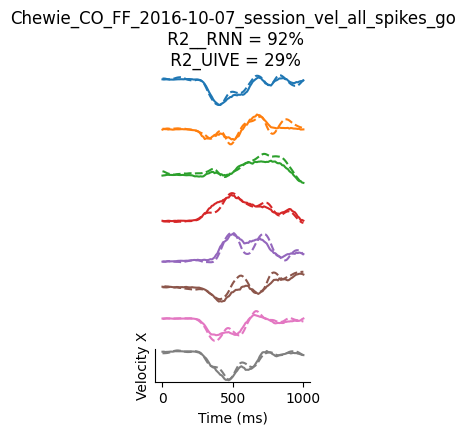

In [13]:
fig, axes = plt.subplots(8, figsize=(2, 4), sharex=True)
dir_index = np.array([
        sorted(set(valid_target_direction)).index(i) for i in valid_target_direction
    ])

vel = valid_behavior
avg_vel = np.zeros_like(vel)
avg_vel_per_epoch = np.zeros_like(vel)
trial_coverage = np.zeros(vel.shape[0],dtype=bool)
for d in range(8):
    mask = d==dir_index
    avg_vel[mask] = vel[mask].mean(0)
    for e in [0,1,2]:
        mask = (d==dir_index) & (e==valid_epoch)
        avg_vel_per_epoch[mask] = vel[mask].mean(0)
        trial_coverage[mask] = 1
assert trial_coverage.all()

trials2plot = get_trials2plot(vel, avg_vel_per_epoch, dir_index, valid_epoch, epoch=1)

plot_beh_pred(valid_behavior[valid_epoch == 1], 
              test_outputs.detach().cpu().numpy()[valid_epoch == 1], 
              dir_index[valid_epoch == 1], 
              trials2plot[valid_epoch == 1], 
              axes, '', 'RNN', component=0, title=dataset_name)


In [18]:
peak_freq = 5
loadpath = f'/disk/scratch/nkudryas/BAND-torch/results/oscillating_score_{short_dataset_name}.npy'
osc_score = np.load(loadpath)
osc_score5 = osc_score[0,0] - osc_score[1,0] # AD - BL

In [ ]:
def cos_similarity(y_true, y_pred, peak_freq=5, dt=0.01):

    from scipy.fft import fft, fftfreq
    
    xf = fft(y_pred,axis=1)  # Compute Fourier transform of y_pred [trials, time bins, 2]
    Sxx_all = (xf * xf.conj()).real # Compute power spectrum
    
    xf_true = fft(y_true,axis=1)  # Compute Fourier transform of y_true
    cos = np.cos(np.angle(xf) - np.angle(xf_true))
    cos_sim = cos.mean(0) # across trials

    faxis = fftfreq(Sxx_all.shape[1]) / dt  # Construct frequency axis
    
    cos_sim = np.asarray(cos_sim) # [freq]
    idx_peak = np.argmin(np.abs(faxis - peak_freq))
    return cos_sim[idx_peak].mean(-1) # mean cos across components

from lfads_torch.metrics import r2_score

def train_and_get_r2(idxs,
    num_epochs = 1000,
    batch_size = 100):
    '''
    Takes in idxs to ablate
    '''

    train_data = train_data_raw.copy()
    train_data = np.delete(train_data,idxs,axis=-1)
    valid_data = valid_data_raw.copy()
    valid_data = np.delete(valid_data,idxs,axis=-1)

    # train an RNN decoder to predict behavior from neural activity
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
    T = train_data.shape[1] # number of time bins
    assert M == 2, 'only 2D behavior is expected'
    rnn = Decoder(input_size=N, 
                rnn_size=128,
                hidden_size=128, 
                output_size=M, 
                seq_len=T, 
                num_layers=1,
                spike_dropout_rate = 0.2,
                dropout=0.3).to(device)


    # Loss and optimizer
    loss = nn.MSELoss()
    # higher weight decay for RNN
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9)

    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(train_data).to(device)
    behaviors = torch.from_numpy(train_behavior).to(device)
    test_inputs = torch.from_numpy(valid_data).to(device)
    test_behaviors = torch.from_numpy(valid_behavior).to(device)

    # Train the model
    for epoch in range(num_epochs):

        batch_indices = list(range(inputs.shape[0]))
        batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

        # print(batch)

        # Forward pass
        outputs = rnn(inputs[batch])
        cost = loss(outputs, behaviors[batch]) 

        # Backward and optimize
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        scheduler.step(cost)

    # predict on test
    rnn.eval()
    test_outputs = rnn(test_inputs)


    return [cos_similarity(test_behaviors.cpu().numpy(), 
                            test_outputs.detach().cpu().numpy(), peak_freq=peak_freq)] +\
        [cos_similarity(test_behaviors[valid_epoch==e].cpu().numpy(), 
                        test_outputs[valid_epoch==e].detach().cpu().numpy(),
                        peak_freq=peak_freq) for e in [0,1,2]] + \
        [r2_score(test_outputs, test_behaviors).item()] +\
        [r2_score(test_outputs[valid_epoch==e], test_behaviors[valid_epoch==e]).item() for e in [0,1,2]]

N_ablate = [0,2,5] + list(range(10, 100, 10)) # + list(range(100,osc_score.shape[0],25))
top_score = []
rand_score = []
for n_ablate in tqdm(N_ablate):

    if n_ablate == 0:
        idxs = []
    else:
        idxs = np.argsort(osc_score5)[-n_ablate:]
    top_score.append(train_and_get_r2(idxs))

    if n_ablate == 0:
        rand_score.append([None])
    else:
        r_score = []
        for _ in range(5):
            idxs = np.random.choice(range(train_data_raw.shape[-1]),n_ablate,replace=False)
            r_score.append(train_and_get_r2(idxs))
        rand_score.append(r_score)
        


  0%|          | 0/12 [00:00<?, ?it/s]

(11, 5, 4)


Text(0.5, 1.0, 'Chewie_CO_FF_2016-09-15')

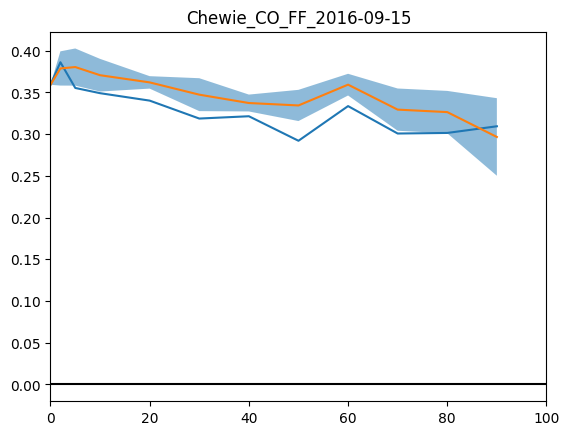

In [ ]:
which_r2 = 6
which_cos = 2
fig, axes = plt.subplots(1,2,figsize=(6,3))
for ax, which in zip(axes, [which_r2, which_cos]):
    top_score_2plot = np.array(top_score)[:,which]
    ax.plot(N_ablate,top_score_2plot,label='top')
    print(np.array(rand_score[1:]).shape)
    rand_score_2plot = np.concatenate([top_score_2plot[0].reshape((-1,1)).repeat(5,axis=-1),
                                    np.array(rand_score[1:])[...,which]])
    ax.plot(N_ablate,np.mean(rand_score_2plot,axis=1),label='rand')
    ax.fill_between(N_ablate,np.mean(rand_score_2plot,axis=1)-np.std(rand_score_2plot,axis=1),
                    np.mean(rand_score_2plot,axis=1)+np.std(rand_score_2plot,axis=1),alpha=0.5)

    # plt.ylim([0.9,.95])
    ax.set_xlim([0,100])
    ax.axhline(0,c='k')
    ax.set_title(short_dataset_name)
    ax.set_ylabel(f'Cosine similarity at {peak_freq} Hz')
    ax.set_xlabel('Number of ablated neurons')
plt.legend()

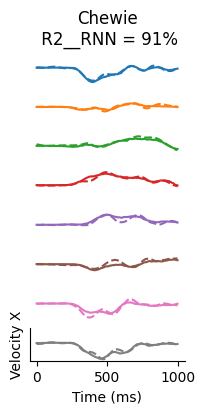

In [61]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = r2_score(pred_vel,vel)
    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%')

def get_trials2plot(pos, avg_pos, dir_index, epochs,epoch=1):
    '''
    Select the trials to plot based on the distance between 
    the average position and the position in single trials

    Parameters
    ----------
    pos : np.ndarray
        The position in single trials
    avg_pos : np.ndarray
        The average position
    dir_index : np.ndarray
        The direction index
    epochs : np.ndarray
        The epochs
    epoch : int, optional
        The epoch to consider, by default 1 (adaptation)

    Returns
    -------
    np.ndarray
        The trials to plot
    '''
    trials2plot = np.zeros_like(epochs)
    for d in np.unique(dir_index):
        mask = (epochs == epoch) & (dir_index == d)
        # print(mask)
        dist = ((pos - avg_pos) ** 2).sum(-1).sum(-1)
        dist[~mask] = -np.inf
        # print(dist)
        idx_max = np.argmax(dist)
        # print(idx_max)
        trials2plot[idx_max] = 1
    return trials2plot

fig, axes = plt.subplots(8, figsize=(2, 4), sharex=True, sharey=True)
dir_index = np.array([
        sorted(set(valid_target_direction)).index(i) for i in valid_target_direction
    ])

vel = valid_behavior
avg_vel = np.zeros_like(vel)
avg_vel_per_epoch = np.zeros_like(vel)
trial_coverage = np.zeros(vel.shape[0],dtype=bool)
for d in range(8):
    mask = d==dir_index
    avg_vel[mask] = vel[mask].mean(0)
    for e in [0,1,2]:
        mask = (d==dir_index) & (e==valid_epoch)
        avg_vel_per_epoch[mask] = vel[mask].mean(0)
        trial_coverage[mask] = 1
assert trial_coverage.all()

trials2plot = get_trials2plot(vel, avg_vel_per_epoch, dir_index, valid_epoch, epoch=1)

plot_beh_pred(valid_behavior[valid_epoch == 1], 
              test_outputs.detach().cpu().numpy()[valid_epoch == 1], 
              dir_index[valid_epoch == 1], 
              trials2plot[valid_epoch == 1], 
              axes, '', 'RNN', component=0, title=dataset_name)

In [36]:
# def save_groud_truth(f):
#     f.create_dataset('train_behavior', data=train_behavior)
#     f.create_dataset('valid_behavior', data=valid_behavior)
#     f.create_dataset('train_target_direction', data=train_target_direction)
#     f.create_dataset('valid_target_direction', data=valid_target_direction)
#     f.create_dataset('train_epoch', data=train_epoch)
#     f.create_dataset('valid_epoch', data=valid_epoch)
#     f.create_dataset('train_inds', data=train_inds)
#     f.create_dataset('valid_inds', data=valid_inds)

# def save_results(f):
#     if f'train_{area}_birnn_pred' in f:
#         del f[f'train_{area}_birnn_pred']
#     if f'test_{area}_birnn_pred' in f:
#         del f[f'test_{area}_birnn_pred']
#     f.create_dataset(f'train_{area}_birnn_pred', data=train_outputs.cpu().detach().numpy())
#     f.create_dataset(f'test_{area}_birnn_pred', data=test_outputs.detach().cpu().numpy())
    

# # check if results file is there
# results_path = f'../../results/{short_dataset_name}.h5'
# if not os.path.exists(results_path):
#     with h5py.File(results_path, 'w') as f:
#         save_groud_truth(f)
#         # save results
#         save_results(f)
# else:
#     with h5py.File(results_path, 'a') as f:
#         save_results(f)

# All in a loop

In [10]:
dataset_name = 'Chewie'
num_epochs = 1000
batch_size = 100

experiments = [
    "Chewie_CO_FF_2016-09-15",
    "Chewie_CO_FF_2016-09-21",
    "Chewie_CO_FF_2016-10-05",
    "Chewie_CO_FF_2016-10-07",
    "Mihili_CO_FF_2014-02-03",  # *
    "Mihili_CO_FF_2014-02-17",  # + (only BL)
    "Mihili_CO_FF_2014-02-18",
    "Mihili_CO_FF_2014-03-07",
]

summary_dict = {}   
for short_dataset_name in tqdm(experiments):

    summary_dict[short_dataset_name] = {}

    # check if results file is there
    results_path = f'../../results/{short_dataset_name}.h5'
    if not os.path.exists(results_path):
        with h5py.File(results_path, 'w') as f:
            save_groud_truth(f)

    for area in ['PMd','M1','all']:

        dataset_name = f'{short_dataset_name}_session_vel_{area}_spikes_go'
        loadpath = f'/disk/scratch2/nkudryas/BAND-torch/datasets/{dataset_name}.h5'

        h5file = h5py.File(loadpath, 'r')

        train_data=h5file['train_recon_data'][()].astype(np.float32)
        valid_data=h5file['valid_recon_data'][()].astype(np.float32)
        train_behavior=h5file['train_behavior'][()].astype(np.float32)
        valid_behavior=h5file['valid_behavior'][()].astype(np.float32)
        train_epoch=h5file['train_epoch'][()].astype(np.float32)
        valid_epoch=h5file['valid_epoch'][()].astype(np.float32)
        train_inds=h5file['train_inds'][()].astype(np.float32)
        valid_inds=h5file['valid_inds'][()].astype(np.float32)

        train_target_direction=h5file['train_target_direction'][()].astype(np.float32)
        valid_target_direction=h5file['valid_target_direction'][()].astype(np.float32)
        # print(h5file.keys())
        h5file.close()        
            
        # train an RNN decoder to predict behavior from neural activity
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
        T = train_data.shape[1] # number of time bins
        assert M == 2, 'only 2D behavior is expected'
        rnn = Decoder(input_size=N, 
                    rnn_size=128,
                    hidden_size=128, 
                    output_size=M, 
                    seq_len=T, 
                    num_layers=1).to(device)


        # Loss and optimizer
        loss = nn.MSELoss()
        # higher weight decay for RNN
        optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

        #scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

        # Convert numpy arrays to torch tensors
        inputs = torch.from_numpy(train_data).to(device)
        behaviors = torch.from_numpy(train_behavior).to(device)
        test_inputs = torch.from_numpy(valid_data).to(device)
        test_behaviors = torch.from_numpy(valid_behavior).to(device)

        # Train the model
        for epoch in range(num_epochs):

            batch_indices = list(range(inputs.shape[0]))
            batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

            # print(batch)

            # Forward pass
            outputs = rnn(inputs[batch])
            cost = loss(outputs, behaviors[batch]) 

            # Backward and optimize
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            scheduler.step(cost)

            # print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.4f}, Test Loss: {test_cost.item():.4f}')
            # print epoch and R2
            if (epoch+1) % 200 == 0:
                # predict on test
                rnn.eval()
                train_outputs = rnn(inputs)
                train_cost = loss(train_outputs, behaviors) 
                test_outputs = rnn(test_inputs)
                test_cost = loss(test_outputs, test_behaviors)
                rnn.train()
                
                print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_cost.item():.4f}, Test Loss: {test_cost.item():.4f}, R2: {r2_score(test_behaviors, test_outputs).item():.4f}')
                       
        final_r2 = r2_score(test_behaviors, test_outputs).item()
        summary_dict[short_dataset_name][f"{area}_R2_all"] = 100*final_r2 

        for e, epoch_name in enumerate(['BL','AD','WO']):
            final_r2 = r2_score(test_behaviors[valid_epoch==e], test_outputs[valid_epoch==e]).item()
            summary_dict[short_dataset_name][f"{area}_R2_{e}"] = 100*final_r2       

        # save predictions
        with h5py.File(results_path, 'a') as f:
            save_results(f)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [200/1000], Loss: 4.8087, Test Loss: 2.1269, R2: 0.9006
Epoch [400/1000], Loss: 4.4517, Test Loss: 1.9175, R2: 0.9102
Epoch [600/1000], Loss: 4.3918, Test Loss: 1.8998, R2: 0.9111
Epoch [800/1000], Loss: 4.3884, Test Loss: 1.8979, R2: 0.9112
Epoch [1000/1000], Loss: 4.3821, Test Loss: 1.8899, R2: 0.9115
Epoch [200/1000], Loss: 5.1836, Test Loss: 2.2311, R2: 0.8950
Epoch [400/1000], Loss: 4.8493, Test Loss: 2.0302, R2: 0.9045
Epoch [600/1000], Loss: 4.7447, Test Loss: 1.9445, R2: 0.9088
Epoch [800/1000], Loss: 4.7259, Test Loss: 1.9275, R2: 0.9095
Epoch [1000/1000], Loss: 4.7265, Test Loss: 1.9303, R2: 0.9094
Epoch [200/1000], Loss: 4.2807, Test Loss: 1.5784, R2: 0.9262
Epoch [400/1000], Loss: 3.9918, Test Loss: 1.5063, R2: 0.9296
Epoch [600/1000], Loss: 3.8847, Test Loss: 1.4991, R2: 0.9298
Epoch [800/1000], Loss: 3.8624, Test Loss: 1.4864, R2: 0.9304


 12%|█▎        | 1/8 [00:33<03:54, 33.54s/it]

Epoch [1000/1000], Loss: 3.8595, Test Loss: 1.4833, R2: 0.9306
Epoch [200/1000], Loss: 5.4435, Test Loss: 2.2755, R2: 0.8875
Epoch [400/1000], Loss: 5.1205, Test Loss: 2.0704, R2: 0.8976
Epoch [600/1000], Loss: 5.0255, Test Loss: 2.0044, R2: 0.9009
Epoch [800/1000], Loss: 5.0088, Test Loss: 1.9843, R2: 0.9018
Epoch [1000/1000], Loss: 5.0054, Test Loss: 1.9833, R2: 0.9019
Epoch [200/1000], Loss: 5.7029, Test Loss: 2.2247, R2: 0.8898
Epoch [400/1000], Loss: 5.4722, Test Loss: 2.0310, R2: 0.8994
Epoch [600/1000], Loss: 5.3868, Test Loss: 1.9626, R2: 0.9028
Epoch [800/1000], Loss: 5.3841, Test Loss: 1.9578, R2: 0.9030
Epoch [1000/1000], Loss: 5.3802, Test Loss: 1.9559, R2: 0.9031
Epoch [200/1000], Loss: 5.0080, Test Loss: 1.8089, R2: 0.9105
Epoch [400/1000], Loss: 4.5876, Test Loss: 1.5558, R2: 0.9231
Epoch [600/1000], Loss: 4.3758, Test Loss: 1.5552, R2: 0.9231
Epoch [800/1000], Loss: 4.3320, Test Loss: 1.5762, R2: 0.9221


 25%|██▌       | 2/8 [01:06<03:20, 33.38s/it]

Epoch [1000/1000], Loss: 4.3125, Test Loss: 1.5776, R2: 0.9220
Epoch [200/1000], Loss: 6.6685, Test Loss: 8.3279, R2: 0.8852
Epoch [400/1000], Loss: 5.1201, Test Loss: 6.7749, R2: 0.9066
Epoch [600/1000], Loss: 4.9917, Test Loss: 6.7573, R2: 0.9068
Epoch [800/1000], Loss: 4.9112, Test Loss: 6.7170, R2: 0.9074
Epoch [1000/1000], Loss: 4.8990, Test Loss: 6.6935, R2: 0.9077
Epoch [200/1000], Loss: 5.2442, Test Loss: 5.9329, R2: 0.9182
Epoch [400/1000], Loss: 4.2295, Test Loss: 5.1108, R2: 0.9295
Epoch [600/1000], Loss: 3.9235, Test Loss: 4.8199, R2: 0.9335
Epoch [800/1000], Loss: 3.8868, Test Loss: 4.7879, R2: 0.9340
Epoch [1000/1000], Loss: 3.8841, Test Loss: 4.7849, R2: 0.9340
Epoch [200/1000], Loss: 3.8077, Test Loss: 5.1076, R2: 0.9296
Epoch [400/1000], Loss: 2.3369, Test Loss: 3.9113, R2: 0.9461
Epoch [600/1000], Loss: 2.0507, Test Loss: 3.7131, R2: 0.9488
Epoch [800/1000], Loss: 1.9909, Test Loss: 3.6750, R2: 0.9493


 38%|███▊      | 3/8 [01:39<02:45, 33.03s/it]

Epoch [1000/1000], Loss: 1.9779, Test Loss: 3.6701, R2: 0.9494
Epoch [200/1000], Loss: 5.5174, Test Loss: 8.0163, R2: 0.8823
Epoch [400/1000], Loss: 4.4320, Test Loss: 7.2383, R2: 0.8937
Epoch [600/1000], Loss: 4.1933, Test Loss: 7.0359, R2: 0.8966
Epoch [800/1000], Loss: 4.1746, Test Loss: 7.0288, R2: 0.8968
Epoch [1000/1000], Loss: 4.1772, Test Loss: 7.0460, R2: 0.8965
Epoch [200/1000], Loss: 4.9069, Test Loss: 6.1109, R2: 0.9092
Epoch [400/1000], Loss: 3.6077, Test Loss: 4.9975, R2: 0.9260
Epoch [600/1000], Loss: 3.3683, Test Loss: 4.7549, R2: 0.9299
Epoch [800/1000], Loss: 3.2868, Test Loss: 4.7254, R2: 0.9302
Epoch [1000/1000], Loss: 3.2849, Test Loss: 4.7710, R2: 0.9294
Epoch [200/1000], Loss: 3.3892, Test Loss: 5.0115, R2: 0.9260
Epoch [400/1000], Loss: 2.2552, Test Loss: 4.1220, R2: 0.9388
Epoch [600/1000], Loss: 2.0637, Test Loss: 3.9855, R2: 0.9409
Epoch [800/1000], Loss: 2.0092, Test Loss: 3.9541, R2: 0.9414


 50%|█████     | 4/8 [02:12<02:12, 33.05s/it]

Epoch [1000/1000], Loss: 2.0033, Test Loss: 3.9518, R2: 0.9414
Epoch [200/1000], Loss: 13.0468, Test Loss: 15.4244, R2: 0.7287
Epoch [400/1000], Loss: 11.9700, Test Loss: 14.9563, R2: 0.7369
Epoch [600/1000], Loss: 11.7110, Test Loss: 14.9421, R2: 0.7371
Epoch [800/1000], Loss: 11.6208, Test Loss: 14.8509, R2: 0.7387
Epoch [1000/1000], Loss: 11.6041, Test Loss: 14.8726, R2: 0.7384
Epoch [200/1000], Loss: 11.0186, Test Loss: 12.0211, R2: 0.7880
Epoch [400/1000], Loss: 9.7048, Test Loss: 10.7409, R2: 0.8106
Epoch [600/1000], Loss: 9.3361, Test Loss: 10.3999, R2: 0.8165
Epoch [800/1000], Loss: 9.2951, Test Loss: 10.4203, R2: 0.8161
Epoch [1000/1000], Loss: 9.2975, Test Loss: 10.4466, R2: 0.8157
Epoch [200/1000], Loss: 7.9516, Test Loss: 9.1029, R2: 0.8398
Epoch [400/1000], Loss: 6.7081, Test Loss: 8.3152, R2: 0.8538
Epoch [600/1000], Loss: 6.5112, Test Loss: 8.1275, R2: 0.8571
Epoch [800/1000], Loss: 6.4592, Test Loss: 8.0285, R2: 0.8588


 62%|██████▎   | 5/8 [02:45<01:38, 32.96s/it]

Epoch [1000/1000], Loss: 6.4478, Test Loss: 8.0248, R2: 0.8589
Epoch [200/1000], Loss: 11.3647, Test Loss: 13.9246, R2: 0.8152
Epoch [400/1000], Loss: 8.6737, Test Loss: 11.4995, R2: 0.8473
Epoch [600/1000], Loss: 8.3315, Test Loss: 11.1332, R2: 0.8522
Epoch [800/1000], Loss: 8.2926, Test Loss: 11.0716, R2: 0.8530
Epoch [1000/1000], Loss: 8.2842, Test Loss: 11.0695, R2: 0.8531
Epoch [200/1000], Loss: 11.2333, Test Loss: 13.3059, R2: 0.8237
Epoch [400/1000], Loss: 9.8443, Test Loss: 11.4830, R2: 0.8477
Epoch [600/1000], Loss: 9.5530, Test Loss: 11.1141, R2: 0.8526
Epoch [800/1000], Loss: 9.5107, Test Loss: 11.0772, R2: 0.8530
Epoch [1000/1000], Loss: 9.4980, Test Loss: 11.0800, R2: 0.8530
Epoch [200/1000], Loss: 6.5413, Test Loss: 8.7341, R2: 0.8840
Epoch [400/1000], Loss: 4.8681, Test Loss: 7.0895, R2: 0.9061
Epoch [600/1000], Loss: 4.6611, Test Loss: 6.9208, R2: 0.9083
Epoch [800/1000], Loss: 4.6195, Test Loss: 6.8795, R2: 0.9088


 75%|███████▌  | 6/8 [03:17<01:05, 32.69s/it]

Epoch [1000/1000], Loss: 4.6089, Test Loss: 6.8693, R2: 0.9089
Epoch [200/1000], Loss: 8.0795, Test Loss: 9.7209, R2: 0.8595
Epoch [400/1000], Loss: 6.7574, Test Loss: 8.7405, R2: 0.8740
Epoch [600/1000], Loss: 6.4803, Test Loss: 8.4656, R2: 0.8780
Epoch [800/1000], Loss: 6.3938, Test Loss: 8.4325, R2: 0.8784
Epoch [1000/1000], Loss: 6.3859, Test Loss: 8.4145, R2: 0.8787
Epoch [200/1000], Loss: 9.8620, Test Loss: 10.9652, R2: 0.8417
Epoch [400/1000], Loss: 8.0979, Test Loss: 9.2250, R2: 0.8668
Epoch [600/1000], Loss: 7.8625, Test Loss: 9.2667, R2: 0.8662
Epoch [800/1000], Loss: 7.7498, Test Loss: 9.1149, R2: 0.8685
Epoch [1000/1000], Loss: 7.7429, Test Loss: 9.0994, R2: 0.8687
Epoch [200/1000], Loss: 6.4014, Test Loss: 8.2611, R2: 0.8816
Epoch [400/1000], Loss: 4.9236, Test Loss: 6.5913, R2: 0.9053
Epoch [600/1000], Loss: 4.6975, Test Loss: 6.4000, R2: 0.9082
Epoch [800/1000], Loss: 4.6637, Test Loss: 6.3729, R2: 0.9085


 88%|████████▊ | 7/8 [03:49<00:32, 32.56s/it]

Epoch [1000/1000], Loss: 4.6580, Test Loss: 6.3626, R2: 0.9087
Epoch [200/1000], Loss: 11.4481, Test Loss: 14.1591, R2: 0.7959
Epoch [400/1000], Loss: 9.5572, Test Loss: 12.4654, R2: 0.8201
Epoch [600/1000], Loss: 9.3085, Test Loss: 12.4131, R2: 0.8209
Epoch [800/1000], Loss: 9.2530, Test Loss: 12.3007, R2: 0.8225
Epoch [1000/1000], Loss: 9.2513, Test Loss: 12.3199, R2: 0.8223
Epoch [200/1000], Loss: 12.3687, Test Loss: 13.6900, R2: 0.8034
Epoch [400/1000], Loss: 9.8248, Test Loss: 12.3443, R2: 0.8227
Epoch [600/1000], Loss: 9.5507, Test Loss: 12.1273, R2: 0.8259
Epoch [800/1000], Loss: 9.4964, Test Loss: 12.1274, R2: 0.8259
Epoch [1000/1000], Loss: 9.4928, Test Loss: 12.1284, R2: 0.8259
Epoch [200/1000], Loss: 7.3938, Test Loss: 9.5404, R2: 0.8625
Epoch [400/1000], Loss: 5.1804, Test Loss: 8.1874, R2: 0.8820
Epoch [600/1000], Loss: 4.8212, Test Loss: 7.9673, R2: 0.8851
Epoch [800/1000], Loss: 4.7523, Test Loss: 7.9573, R2: 0.8853


100%|██████████| 8/8 [04:21<00:00, 32.71s/it]

Epoch [1000/1000], Loss: 4.7407, Test Loss: 7.9705, R2: 0.8851


FileNotFoundError: [Errno 2] No such file or directory: './results/biRNN_decoder_R2.csv'

In [11]:
# save summary
with open("../../results/biRNN_decoder_R2.csv", "w") as f:
    get_column_names = summary_dict[experiments[0]].keys()
    f.write("Dataset,")
    for key in get_column_names:
        f.write(f"{key},\t")
    f.write('\n')
    for key in summary_dict.keys():
        f.write(f"{key},\t")
        for key2 in get_column_names:
            f.write(f"{summary_dict[key][key2]},\t")
        f.write('\n')